In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [45]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [9]:
from simulation.gen_pend import *

param_dists = {
    'q': stats.uniform(-np.pi, 2 * np.pi),
    'v': stats.uniform(-6., 12),
    'b': stats.uniform(0., .2)
}

times, trajs = gen_trajs(50_000, 5., 50, param_dists)

In [10]:
trajs.shape

(50000, 2, 50)

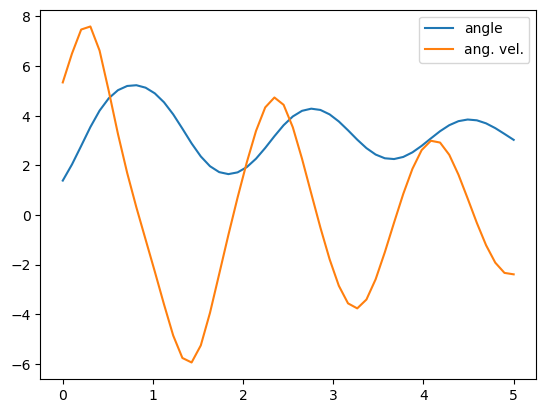

In [15]:
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

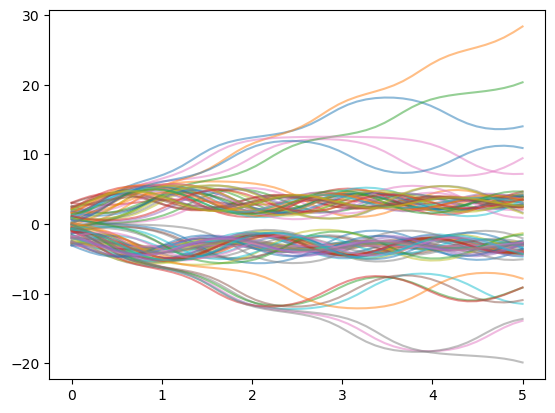

In [16]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)

## 1D Conv

In [69]:
X_tr, X_val = random_split(torch.tensor(trajs), (30_000, 20_000))
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [73]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self, traj_len, kernel_size=3):
        super(Conv1DAutoencoder, self).__init__()
        self.kernel_size = kernel_size
        self.padding = (kernel_size - 1) // 2

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=kernel_size, padding='same'),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: (batch_size, 16, 25)

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding='same'),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: (batch_size, 32, 12) (Note: floor division)

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding='same'),
            nn.ReLU(True),
            # No MaxPooling here, as we need to flatten
        )

        self.flattened_size = 64 * (traj_len // 4)

        self.fc_encode = nn.Linear(self.flattened_size, 2) # Encode to 2D latent vector

        self.fc_decode = nn.Linear(2, self.flattened_size)

        self.decoder = nn.Sequential(
            # Upsample to the shape before the last convolution in the encoder
            # We need to reverse the convolutions and pooling operations
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True), # Upsample to 24 (or close to 25)

            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True), # Upsample to 48 (or close to 50)

            nn.ConvTranspose1d(in_channels=16, out_channels=2, kernel_size=self.kernel_size, padding=self.padding),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flattened_size)
        latent_vector = self.fc_encode(x)

        x = self.fc_decode(latent_vector)
        x = x.view(-1, 64, 12) # Reshape to the shape before flattening for decoder
        x = self.decoder(x)

        # Crop or pad if necessary to ensure the output is (batch_size, 2, 50)
        if x.shape[2] != 50:
            if x.shape[2] > 50:
                x = x[:, :, :50]
            else:
                padding_needed = 50 - x.shape[2]
                # Pad at the end of the sequence dimension
                x = torch.nn.functional.pad(x, (0, padding_needed))
        return x, latent_vector

In [74]:
model = Conv1DAutoencoder().to(device)

opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in model.parameters())}')

TypeError: Conv1DAutoencoder.__init__() missing 1 required positional argument: 'traj_len'

In [75]:
n_epochs = 1

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dl_tr):
        x = x.to(device)

        opt.zero_grad()
        rec, lat = model(x)
        loss = loss_fn(rec, x)
        loss.backward()
        opt.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(dl_tr.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0

    for batch_idx, x in enumerate(dl_val):
        x = x.to(device)

        rec, lat = model(x)
        loss = loss_fn(rec, x)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(dl_val.dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

RuntimeError: shape '[-1, 0]' is invalid for input of size 196608

In [70]:
PATH = './1d_conv_state_dict.pth'
torch.save(model.state_dict(), PATH)

In [11]:
PATH = './1d_conv_state_dict.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

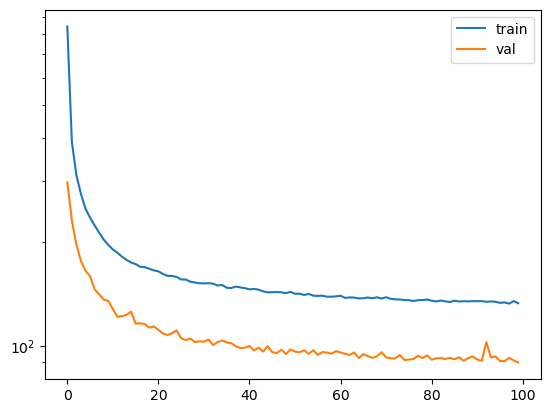

In [48]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()

In [51]:
model.to("cpu")
with torch.no_grad():
    _, latents = model(torch.tensor(trajs))

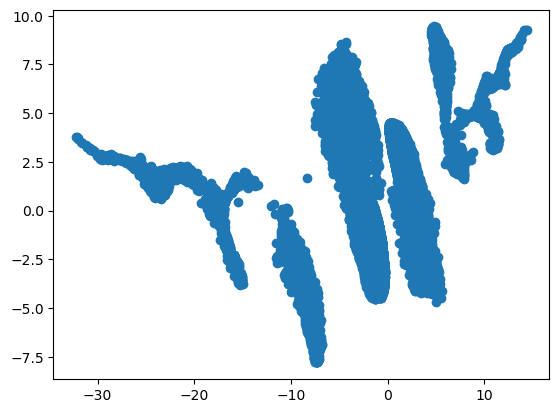

In [52]:
plt.scatter(*latents.T)

In [76]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_8450/4048237539.py:3: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



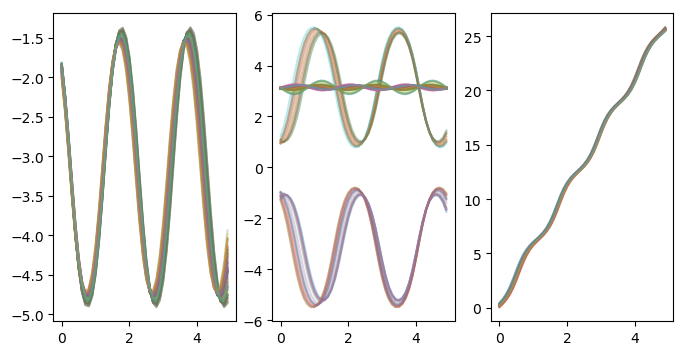

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
plot_most_similar(latents, np.array([-10, -10]), 100, axs[0])
plot_most_similar(latents, np.array([0, 0]), 100, axs[1])
plot_most_similar(latents, np.array([30, 20]), 50, axs[2])

In [24]:
from latent_app import create_dash_app

In [26]:
app = create_dash_app(latents.numpy(), trajs[:, 0])
app.run()

## Testing trajectories outside of the training distribution

In [32]:
_, traj_ood = gen_one_traj(5., 50, np.pi/4, 10., 3.)

with torch.no_grad():
    _, latents_ood = model(torch.tensor(traj_ood))
latents_ood

tensor([[-2.8979,  3.5439]])

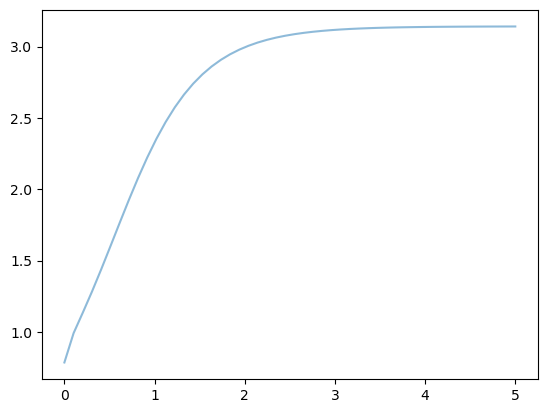

In [33]:
plt.plot(times, traj_ood[0, 0], alpha=.5)

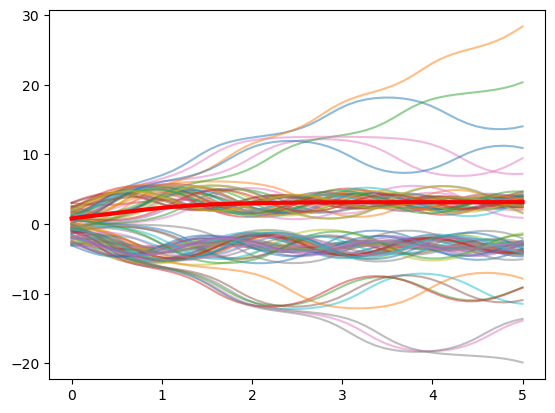

In [34]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_ood[0, 0], color='red', lw=3)

## Using CD poly

In [35]:
from cd_poly.cd_poly import *

In [36]:
p = CDPolynomial(latents, degree=6)
alpha = p(latents).max()

In [37]:
alpha

np.float64(6525.232838208118)

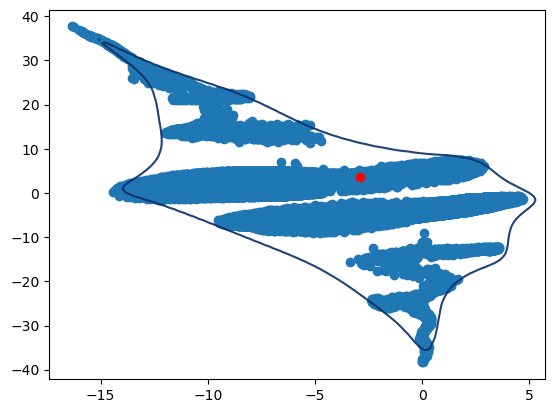

In [38]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_ood.T, color='red')
plot_level_set(p, alpha / 10, ax)

## Testing custom trajectories

Let's create a custom trajectory that couldn't be generated by the simulation with our distribution of parameters.

In [39]:
amp = 1.5
freq = 13.
const = 4
custom = np.array([amp * np.sin(freq * times) + const * times, amp * freq * np.cos(freq * times) + const])

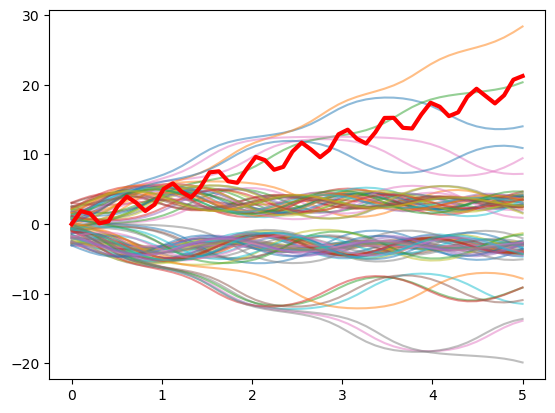

In [40]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, custom[0], color='red', lw=3)

In [41]:
with torch.no_grad():
    _, latents_custom = model(torch.tensor(custom.reshape(1, 2, -1)))
latents_custom

tensor([[-23.8442,  15.3420]])

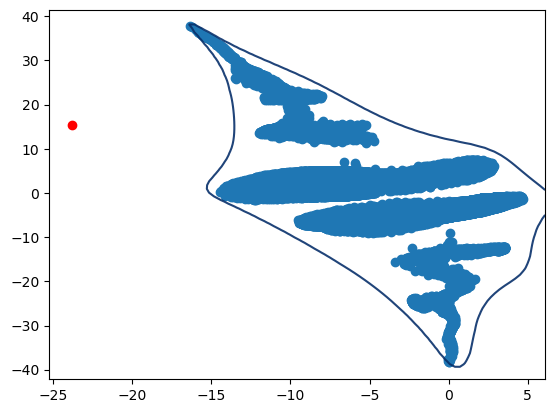

In [42]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_custom.T, color='red')
plot_level_set(p, alpha, ax)